In [1]:
import math
import torch

from matplotlib import pyplot as plt
%matplotlib inline

import os
import argparse
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import KFold

import gpytorch
import itertools


In [2]:
from m3gpr.config import get_cfg_defaults_all
from m3gpr.load_data import Data_set
from m3gpr.models import singleGP_gpytorch,rf_sklearn,singleGP_gpytorch_train,singleGP_gpytorch_reference,MultitaskGPModel,MTMOGP
from m3gpr.train import CV_Trainer

In [3]:
cfg = get_cfg_defaults_all()
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
parser = argparse.ArgumentParser(description="Configure files")
parser.add_argument("--cfg", required=True, help="path to config file", type=str)
args = parser.parse_args(['--cfg', 'data/harpoon_dataset.yaml'])
cfg.merge_from_file(args.cfg)

cfg.freeze()
setup_data = Data_set(cfg, 1)

#df_x, df_y_wide, df_y_long = setup_data.Load_data_set()
df_x, df_y,ls_X_train,ls_X_test,ls_y_train,ls_y_test, obj_y_scaler= setup_data.Load_data_set()
print(df_x.shape)
print(df_y.shape)
#print(df_y_wide.shape)
#print(df_y_long.shape)

ohe
(72, 10)
(72, 2)


In [ ]:
"""
kfold = KFold(n_splits=cfg.MODEL.N_CV
              , shuffle=True,random_state=0)

ls_X_train = []
ls_X_test = []
ls_y_train = []
ls_y_test = []

X = df_x.to_numpy()
Y = df_y_long.to_numpy()
ls_y_scaler = []

#y_scale_label = 'y-stand'

for train_ix, test_ix in kfold.split(X):
    X_train, X_test=X[train_ix,:], X[test_ix,:]
    y_train, y_test= Y[train_ix],Y[test_ix]

    df_X_train = pd.DataFrame(X_train,columns = df_x.columns)
    df_X_test = pd.DataFrame(X_test,columns = df_x.columns)

    df_y_train = pd.DataFrame(y_train,columns = df_y_long.columns)
    df_y_test = pd.DataFrame(y_test,columns = df_y_long.columns)

    if cfg.MODEL.X_SCALE != 'no-x-scale':
        if cfg.MODEL.X_SCALE == 'x-minmax':
            x_scaler = MinMaxScaler()
        elif cfg.MODEL.X_SCALE == 'x-stand':
            x_scaler = StandardScaler
        
        xct = ColumnTransformer([('x_scaler',x_scaler,df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
        scaled_X_train=xct.fit_transform(df_X_train)
        scaled_X_test=xct.transform(df_X_test)
    else:
        scaled_X_train= X_train
        scaled_X_test=X_test
    
    if cfg.MODEL.Y_SCALE == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        #scaled_y_test= y_scaler.transform(df_y_test)
    elif cfg.MODEL.Y_SCALE == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        #scaled_y_test= y_scaler.transform(df_y_test)
    elif cfg.MODEL.Y_SCALE == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        scaled_y_test = df_y_test.to_numpy()
        #scaled_y_test= y_scaler.transform(df_y_test)
    else:
        scaled_y_train = df_y_train.to_numpy()
        
    scaled_y_test = df_y_test.to_numpy()

    ls_X_train.append(torch.Tensor(scaled_X_train))
    ls_X_test.append(torch.Tensor(scaled_X_test))
    ls_y_train.append(torch.Tensor(scaled_y_train))
    ls_y_test.append(torch.Tensor(scaled_y_test))"
"""

## Single GP Cross-Validation

In [22]:


cols_target = df_y_long.columns
cols_target_wide = df_y_wide.columns


num_outputs = cfg.DATA.NUM_OUTPUTS
if cfg.MODEL.SPLIT == 'by-task':
  num_tasks = cfg.DATA.NUM_TASKS
else:
  num_tasks = 1
num_iters = cfg.MODEL.NUM_TRAIN_ITERS

num_total_output = num_outputs*num_tasks
num_cols = num_total_output*cfg.MODEL.N_CV #cfg.MODEL.N_CV is number of cv


ls_init_len = [2.0,3.0,4.0]
ls_lr = [0.1,0.15,0.2,0.25]
ls_n_iter = [200,300]
combs = list(itertools.product(ls_init_len,ls_lr,ls_n_iter))
arr_cv_mae = np.zeros((2,len(combs))) #train,test
arr_cv_r2 = np.zeros((2,len(combs))) #train,test
arr_cv_err = np.zeros((2,len(combs))) #train,test

mean_arr_cv_mae = np.zeros((2,len(combs))) #train,test
mean_arr_cv_r2 = np.zeros((2,len(combs))) #train,test
mean_arr_cv_err = np.zeros((2,len(combs))) #train,test

ls_arr_cv_mae = [arr_cv_mae,arr_cv_mae.copy()]
ls_arr_cv_r2 = [arr_cv_r2,arr_cv_r2.copy()]
ls_arr_cv_err = [arr_cv_err,arr_cv_err.copy()]

ls_model_from_combs = [[],[]]


for i in range(0,len(combs)):
  init_len,lr,n_iter = combs[i]
  #arr_train_metrics = np.zeros((11,num_cols))
  #arr_test_metrics = np.zeros((11,num_cols))
  for j,_ in enumerate(cols_target):
    arr_train_metrics = np.zeros((11,cfg.MODEL.N_CV))
    arr_test_metrics = np.zeros((11,cfg.MODEL.N_CV))
    
    for batch_ind in range(cfg.MODEL.N_CV):
    
      #a = j + len(cols_target)*batch_ind
      a = batch_ind
      tmp_col_y = 'Batch_'+str(batch_ind+1)
      if cfg.MODEL.MODEL_NAME == 'singleGP':
        
          t_train_x = ls_X_train[batch_ind]
          t_train_y = ls_y_train[batch_ind][:,j].flatten()
          t_test_x = ls_X_test[batch_ind]
          t_test_y = ls_y_test[batch_ind][:,j].flatten()
          train_mean,train_lower,train_upper,model = singleGP_gpytorch_train(t_train_x,t_train_y,training_iter = n_iter,init_len_scale = init_len,my_lr = lr)
          
          ls_model_from_combs[j].append(model)

          # Set into eval mode
          model.eval()
          model.likelihood.eval()
    
          with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_pred = model.likelihood(model(t_test_x))   
            test_mean = test_pred.mean
            test_lower, test_upper = test_pred.confidence_region()
          
          """
          if cfg.MODEL.Y_SCALE=='no-y-scale':
            arr_train_x = t_train_x.detach().numpy()
            arr_train_y = t_train_y.detach().numpy()
            arr_test_x = t_test_x.detach().numpy()
            arr_test_y = t_test_y.detach().numpy()
            arr_test_mean = test_mean.detach().numpy()
            arr_test_lower = test_lower.detach().numpy()
            arr_test_upper = test_upper.detach().numpy()

            arr_train_mean = train_mean.detach().numpy()
            arr_train_lower = train_lower.detach().numpy()
            arr_train_upper = train_upper.detach().numpy()
          else:
            arr_train_x = t_train_x.detach().numpy()
            arr_train_y = y_scaler.inverse_transform(t_train_y)
            arr_test_x = t_test_x.detach().numpy()
            arr_test_y = t_test_y.detach().numpy()

            arr_train_mean = y_scaler.inverse_transform(train_mean)
            arr_train_lower = y_scaler.inverse_transform(train_lower)
            arr_train_upper = y_scaler.inverse_transform(train_upper)

            rr_test_mean = y_scaler.inverse_transform(test_mean)
            arr_test_lower = y_scaler.inverse_transform(test_lower)
            arr_test_upper = y_scaler.inverse_transform(test_upper)

          """
          arr_test_y = t_test_y.detach().numpy()
          arr_train_y = t_train_y.detach().numpy()
          arr_test_mean = test_mean.detach().numpy()
          arr_test_lower = test_lower.detach().numpy()
          arr_test_upper = test_upper.detach().numpy()

          arr_train_mean = train_mean.detach().numpy()
          arr_train_lower = train_lower.detach().numpy()
          arr_train_upper = train_upper.detach().numpy()
          

          y_true = arr_test_y
          y_pred = arr_test_mean
          y_true_train = arr_train_y
          mean_train_pred = arr_train_mean
          std_train_pred = arr_train_mean - arr_train_lower
          std_test_pred = arr_test_mean - arr_test_lower

          train_comp = np.concatenate((y_true_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
          df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
          df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
          df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
          df_train_comp['mode'] = 'train'
    
          test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
          df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
          df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
          df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
          df_test_comp['mode'] = 'test'
    
          df_comp = pd.concat([df_train_comp,df_test_comp])
          df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

          arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
          arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
          arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
          arr_test_metrics[3,a] = np.round(metrics.root_mean_squared_error(y_true, y_pred),2)
          arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
          arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
          arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
          arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
          if cfg.MODEL.MODEL_NAME != 'rf':
            arr_test_metrics[8,a] = round(np.mean(std_test_pred),2)
            arr_test_metrics[9,a] = round(np.min(std_test_pred),2)
            arr_test_metrics[10,a] = round(np.max(std_test_pred),2)

          arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[3,a] = np.round(metrics.root_mean_squared_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[5,a] = round(metrics.max_error(y_true_train, mean_train_pred),2)
          arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_true_train, mean_train_pred),2)
          arr_train_metrics[7,a] = round(metrics.r2_score(y_true_train, mean_train_pred),2)
          if cfg.MODEL.MODEL_NAME != 'rf':
            arr_train_metrics[8,a] = round(np.mean(std_train_pred),2)
            arr_train_metrics[9,a] = round(np.min(std_train_pred),2)
            arr_train_metrics[10,a] = round(np.max(std_train_pred),2)
        
    ls_arr_cv_mae[j][0,i] = np.mean(arr_train_metrics[0,:])
    ls_arr_cv_mae[j][1,i] = np.mean(arr_test_metrics[0,:])

    ls_arr_cv_r2[j][0,i] = np.mean(arr_train_metrics[7,:])
    ls_arr_cv_r2[j][1,i] = np.mean(arr_test_metrics[7,:])

    ls_arr_cv_err[j][0,i] = np.mean(arr_train_metrics[8,:])
    ls_arr_cv_err[j][1,i] = np.mean(arr_test_metrics[8,:])
  mean_arr_cv_mae[:,i] = (ls_arr_cv_mae[0][:,i]+ls_arr_cv_mae[1][:,i])/2
  mean_arr_cv_r2[:,i] = (ls_arr_cv_r2[0][:,i]+ls_arr_cv_r2[1][:,i])/2
  mean_arr_cv_err[:,i] = (ls_arr_cv_err[0][:,i]+ls_arr_cv_err[1][:,i])/2
  
  """
  arr_cv_mae[0,i] = np.mean(arr_train_metrics[0,:])
  arr_cv_mae[1,i] = np.mean(arr_test_metrics[0,:])

  arr_cv_r2[0,i] = np.mean(arr_train_metrics[7,:])
  arr_cv_r2[1,i] = np.mean(arr_test_metrics[7,:])

  arr_cv_err[0,i] = np.mean(arr_train_metrics[8,:])
  arr_cv_err[1,i] = np.mean(arr_test_metrics[8,:])"
  """


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/mode

In [26]:
"""
print(cols_target[0])
best_idx_0 = np.argmin(ls_arr_cv_mae[0][1,:])
print(best_idx_0)
print(np.min(ls_arr_cv_mae[0][1,:]))

best_idx_0 = np.argmax(ls_arr_cv_r2[0][1,:])
print(best_idx_0)
print(np.max(ls_arr_cv_r2[0][1,:]))
print(ls_arr_cv_err[0][1,best_idx_0])
print(combs[best_idx_0])

print(cols_target[1])
best_idx_1 = np.argmin(ls_arr_cv_mae[1][1,:])
print(best_idx_1)
print(np.min(ls_arr_cv_mae[1][1,:]))

best_idx_1 = np.argmax(ls_arr_cv_r2[1][1,:])
print(best_idx_1)
print(np.max(ls_arr_cv_r2[1][1,:]))
print(ls_arr_cv_err[1][1,best_idx_1])
print(combs[best_idx_1])
"""
print('both targets')
best_idx = np.argmin(mean_arr_cv_mae[1,:])

print('best_idx',best_idx)
print('mean min mae',np.min(mean_arr_cv_mae[1,:]))

best_idx = np.argmax(mean_arr_cv_r2[1,:])
print('best_idx',best_idx)
print('mean max r2',np.max(mean_arr_cv_r2[1,:]))
print('mean min err',mean_arr_cv_err[1,best_idx])


print('min mae target 0',ls_arr_cv_mae[0][1,best_idx])
print('min mae target 1',ls_arr_cv_mae[1][1,best_idx])

print('max r2 target 0',ls_arr_cv_r2[0][1,best_idx])
print('max r2 target 1',ls_arr_cv_r2[1][1,best_idx])

print('min err target 0',ls_arr_cv_err[0][1,best_idx])
print('min err target 1',ls_arr_cv_err[1][1,best_idx])

"""
print('both targets')
best_idx = np.argmin(arr_cv_mae[1,:])
print(best_idx)
print(np.min(arr_cv_mae[1,:]))

best_idx = np.argmax(arr_cv_r2[1,:])
print(best_idx)
print(np.max(arr_cv_r2[1,:]))
print(arr_cv_err[1,best_idx])
"""

print(combs[best_idx])
ls_best_model = [ls_model_from_combs[0][best_idx],ls_model_from_combs[1][best_idx]]



both targets
best_idx 1
mean min mae 0.5430000022053718
best_idx 1
mean max r2 0.665
mean min err 1.5440000116825106
min mae target 0 0.34599999487400057
min mae target 1 0.7400000095367432
max r2 target 0 0.688
max r2 target 1 0.642
min err target 0 0.8600000023841858
min err target 1 2.228000020980835
(2.0, 0.1, 300)


In [27]:
##Split the data into training and testing sets
if cfg.MODEL.SPLIT == 'by-task':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_wide, test_size=0.2, random_state=0)
elif cfg.MODEL.SPLIT == 'combine':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_long, test_size=0.2, random_state=0)

if cfg.MODEL.X_SCALE == 'x-minmax':
    x_scaler = MinMaxScaler()
elif cfg.MODEL.X_SCALE == 'x-stand':
    x_scaler = StandardScaler()

xct = ColumnTransformer([('x_scaler',x_scaler,df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

if cfg.MODEL.X_SCALE != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train)
        t_test_x = torch.Tensor(scaled_X_test)
else:
        t_train_x = torch.Tensor(df_X_train.to_numpy())
        t_test_x = torch.Tensor(df_X_test.to_numpy())

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_56113/742115571.py:173: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_56113/742115571.py:176: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Test Metrics:
        _Dimer_HMW_ _Monomer
MAE            0.04     0.77
MAE2           0.03     0.67
MSE            0.00     0.90
RMSE           0.05     0.95
MAPE           0.02     0.01
MAXE           0.14     1.98
EVS            1.00     0.70
R2             1.00     0.58
AVG_STD        0.11     0.03
MIN_STD        0.10     0.03
MAX_STD        0.11     0.03
Train Metrics:
        _Dimer_HMW_ _Monomer
MAE            0.11     0.76
MAE2           0.02     0.66
MSE            0.06     0.90
RMSE           0.25     0.95
MAPE           0.04     0.01
MAXE           1.18     2.30
EVS            0.94     0.78
R2             0.94     0.69
AVG_STD        0.14     0.03
MIN_STD        0.08     0.03
MAX_STD        0.66     0.03


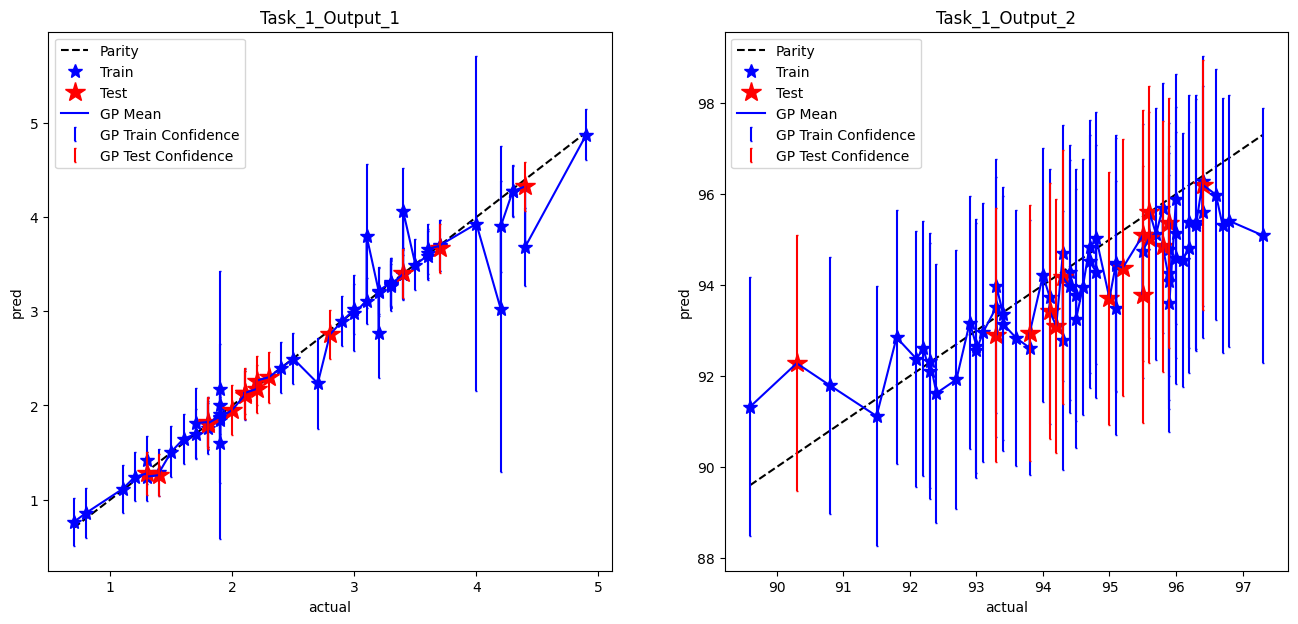

In [41]:
#singleGP and rf


is_plot_imp = True #for random forest
uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target = df_y_long.columns
cols_target_plot = df_y_train.columns
figPath = setup_data.output_path

plot_axis_lb = df_y_long[cols_target].min(axis = 0) - 0.4* df_y_long[cols_target].std(axis = 0)
plot_axis_ub = df_y_long[cols_target].max(axis = 0) + 0.4* df_y_long[cols_target].std(axis = 0)

num_outputs = cfg.DATA.NUM_OUTPUTS
if cfg.MODEL.SPLIT == 'by-task':
  num_tasks = cfg.DATA.NUM_TASKS
else:
  num_tasks = 1
num_iters = cfg.MODEL.NUM_TRAIN_ITERS

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

ls_df_comp_sorted = []
ls_df_train_comp = []
ls_df_test_comp = []
# Start Training Process

for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    #j = 0
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_plot[a]

    if cfg.MODEL.MODEL_NAME == 'rf':
      y_train = df_y_train[tmp_col_y].to_numpy()
      y_true = df_y_test[tmp_col_y].to_numpy()
      mean_train_pred, mean_test_pred, rf_grid = rf_sklearn(scaled_X_train,y_train,scaled_X_test,
                                                       cv_option = 'shuffle-split')
      
      
      y_pred = mean_test_pred
      best_rf = rf_grid.best_estimator_
      importances=best_rf.feature_importances_
      std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
      cols_feature_new = df_x.columns
      forest_importances = pd.Series(importances, index=cols_feature_new)
      
      if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))


    elif cfg.MODEL.MODEL_NAME == 'singleGP':
      if cfg.MODEL.Y_SCALE == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      elif cfg.MODEL.Y_SCALE == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      elif cfg.MODEL.Y_SCALE == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      else:
        scaled_y_train = df_y_train[[tmp_col_y]].to_numpy()

      t_train_y = torch.Tensor(scaled_y_train).flatten()
      #test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = singleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = num_iters)
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = singleGP_gpytorch_reference(ls_best_model[j],t_train_x,t_test_x)
    

      t_test_y = torch.Tensor(df_y_test.to_numpy())[:,a]
      arr_train_x = t_train_x.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      if cfg.MODEL.Y_SCALE=='no-y-scale':
        arr_train_y = t_train_y.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(t_train_y.reshape(-1,1))
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    if cfg.MODEL.MODEL_NAME != 'rf':
      df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
      df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    if cfg.MODEL.MODEL_NAME != 'rf':
      df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
      df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    ls_df_train_comp.append(df_train_comp)
    ls_df_test_comp.append(df_test_comp)
    ls_df_comp_sorted.append(df_comp_sorted)
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = np.round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = np.round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
    arr_test_metrics[5,a] = np.round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = np.round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = np.round(metrics.r2_score(y_true, y_pred),2)
    if cfg.MODEL.MODEL_NAME != 'rf':
      arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
      arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
      arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    if cfg.MODEL.MODEL_NAME != 'rf':
      arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
      arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
      arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)

#Initialize parity plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_plot[a]

    df_train_comp = ls_df_train_comp[a]
    df_test_comp = ls_df_test_comp[a]
    df_comp_sorted = ls_df_comp_sorted[a]

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      if cfg.MODEL.MODEL_NAME != 'rf':
        yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
        yerr = yerr.values.tolist()
        yerr_train = df_train_comp['pred'] - df_train_comp['lower']
        yerr_train = yerr_train.values.tolist()
        yerr_test = df_test_comp['pred'] - df_test_comp['lower']
        yerr_test = yerr_test.values.tolist()
        y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
        y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    
    if cfg.MODEL.MODEL_NAME == 'rf':
      y_axes[a].legend(['parity','train','test','GP Mean'])
    else:
      y_axes[a].legend(['Parity','Train','Test','GP Mean','GP Train Confidence','GP Test Confidence'])
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

#pd.set_option('display.float_format', np.format_float_positional)

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_plot, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])


df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_plot, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])



f = "{:,.2f}"
for col in df_test_metrics:
  df_test_metrics[col] = df_test_metrics[col].map(lambda x: f.format(x))


for col in df_train_metrics:
  df_train_metrics[col] = df_train_metrics[col].map(lambda x: f.format(x))

print('Test Metrics:')
print(df_test_metrics)
print('Train Metrics:')
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## MO Cross-Validation

In [4]:
mo_cv_trainer = CV_Trainer(cfg,ls_X_train,ls_X_test,ls_y_train,ls_y_test,obj_y_scaler)
combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err = mo_cv_trainer.set_up_mo_cv()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no

In [6]:
print('both targets')
best_idx = np.argmin(mean_arr_cv_mae[1,:])

print('best_idx',best_idx)
print('mean min mae',np.min(mean_arr_cv_mae[1,:]))

best_idx = np.argmax(mean_arr_cv_r2[1,:])
#print('best_idx',best_idx)
print('mean max r2',np.max(mean_arr_cv_r2[1,:]))
print('mean min err',mean_arr_cv_err[1,best_idx])

for j in range(cfg.DATA.NUM_OUTPUTS):
    print('min mae of target',j,ls_arr_cv_mae[j][1,best_idx])
#print('min mae target 1',ls_arr_cv_mae[1][1,best_idx])

    print('max r2 of target',j,ls_arr_cv_r2[j][1,best_idx])
#print('max r2 target 1',arr_cv_r2_1[1,best_idx])

    print('min err of target',j,ls_arr_cv_err[j][1,best_idx])
#print('min err target 1',arr_cv_err_1[1,best_idx])

print(combs[best_idx])


both targets
best_idx 17
mean min mae 0.418
mean max r2 0.762
mean min err 1.0180000000000002
min mae of target 0 0.0
max r2 of target 0 0.0
min err of target 0 0.0
min mae of target 1 0.51
max r2 of target 1 0.78
min err of target 1 1.254


NameError: name 'combs' is not defined

In [6]:


cols_target = df_y.columns


num_outputs = cfg.DATA.NUM_OUTPUTS
if cfg.MODEL.SPLIT == 'by-task':
  num_tasks = cfg.DATA.NUM_TASKS
else:
  num_tasks = 1
num_iters = cfg.MODEL.NUM_TRAIN_ITERS

num_total_output = num_outputs*num_tasks
num_cols = num_total_output*cfg.MODEL.N_CV #5 is number of cv


ls_arr_train_metrics = []
ls_arr_test_metrics = []

ls_model_from_combs = []


ls_lr = [0.1,0.15,0.2,0.25,0.3,0.35,0.40]
ls_n_iter = [200,300,400,500,700]
combs = list(itertools.product(ls_lr,ls_n_iter))

mean_arr_cv_mae = np.zeros((2,len(combs))) #train,test
mean_arr_cv_r2 = np.zeros((2,len(combs))) #train,test
mean_arr_cv_err = np.zeros((2,len(combs))) #train,test

ls_arr_cv_mae = [np.zeros((2,len(combs))) for _ in range(num_total_output)]
ls_arr_cv_r2 = [np.zeros((2,len(combs))) for _ in range(num_total_output)]
ls_arr_cv_err = [np.zeros((2,len(combs))) for _ in range(num_total_output)]

for i in range(0,len(combs)):
  lr,n_iter = combs[i]
  arr_train_metrics = np.zeros((11,num_cols))
  arr_test_metrics = np.zeros((11,num_cols))
  for batch_ind in range(cfg.MODEL.N_CV):
    t_train_x = ls_X_train[batch_ind]
    t_train_y = ls_y_train[batch_ind]
    t_test_x = ls_X_test[batch_ind]
    t_test_y = ls_y_test[batch_ind]

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs,rank = num_outputs)
    model = MultitaskGPModel(t_train_x, t_train_y, likelihood, num_tasks= num_outputs, rank = num_outputs)
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = n_iter#500
    for _ in range(training_iterations):
        optimizer.zero_grad()
        output = model(t_train_x)
        loss = -mll(output, t_train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()


    # Set into eval mode
    model.eval()
    likelihood.eval()

    ls_model_from_combs.append(model)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    
    if cfg.MODEL.Y_SCALE=='no-y-scale':
      arr_train_x = t_train_x.detach().numpy()
      arr_train_y = t_train_y.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()
      arr_test_mean = test_mean.detach().numpy()
      arr_test_lower = test_lower.detach().numpy()
      arr_test_upper = test_upper.detach().numpy()

      arr_train_mean = train_mean.detach().numpy()
      arr_train_lower = train_lower.detach().numpy()
      arr_train_upper = train_upper.detach().numpy()
    else:
      y_scaler = setup_data.y_scaler[batch_ind]
      arr_train_x = t_train_x.detach().numpy()
      arr_train_y = y_scaler.inverse_transform(t_train_y)
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      arr_train_mean = y_scaler.inverse_transform(train_mean)
      arr_train_lower = y_scaler.inverse_transform(train_lower)
      arr_train_upper = y_scaler.inverse_transform(train_upper)

      arr_test_mean = y_scaler.inverse_transform(test_mean)
      arr_test_lower = y_scaler.inverse_transform(test_lower)
      arr_test_upper = y_scaler.inverse_transform(test_upper)

    for j,_ in enumerate(cols_target):
    
      #a = j + len(cols_target)*batch_ind
      a = batch_ind + cfg.MODEL.N_CV*j
      tmp_col_y = 'Batch_'+str(batch_ind+1)

      r_train_y = arr_train_y[:,j]
      r_train_mean_y =arr_train_mean[:,j]
      r_train_lower_y =arr_train_lower[:,j]
      r_train_upper_y =arr_train_upper[:,j]
      r_train_std = r_train_mean_y - r_train_lower_y

      r_test_y = arr_test_y[:,j]
      r_test_mean_y =arr_test_mean[:,j]
      r_test_lower_y =arr_test_lower[:,j]
      r_test_upper_y =arr_test_upper[:,j]
      r_test_std = r_test_mean_y - r_test_lower_y
    
      train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
      df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
      df_train_comp['upper'] = r_train_upper_y
      df_train_comp['lower'] = r_train_lower_y
      df_train_comp['mode'] = 'train'
    
      test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
      df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
      df_test_comp['upper'] = r_test_upper_y
      df_test_comp['lower'] = r_test_lower_y
      df_test_comp['mode'] = 'test'
    
      df_comp = pd.concat([df_train_comp,df_test_comp])
      df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

      y_true = r_test_y
      y_pred = r_test_mean_y
      y_train = r_train_y
      mean_train = r_train_mean_y
    

      arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
      arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
      arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
      arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
      arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
      arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
      arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
      arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
      arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
      arr_test_metrics[9,a] = round(np.min(r_test_std),2)
      arr_test_metrics[10,a] = round(np.max(r_test_std),2)

      arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
      arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
      arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
      arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
      arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
      arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
      arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
      arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
      arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
      arr_train_metrics[9,a] = round(np.min(r_train_std),2)
      arr_train_metrics[10,a] = round(np.max(r_train_std),2)
      arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
      arr_train_metrics[9,a] = round(np.min(r_train_std),2)
      arr_train_metrics[10,a] = round(np.max(r_train_std),2)
      
  ls_arr_train_metrics.append(arr_train_metrics)
  ls_arr_test_metrics.append(arr_test_metrics)
  ls_arr_cv_mae[j][0,i] = np.mean(arr_train_metrics[0,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])
  ls_arr_cv_mae[j][1,i] = np.mean(arr_test_metrics[0,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])

  ls_arr_cv_r2[j][0,i] = np.mean(arr_train_metrics[7,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])
  ls_arr_cv_r2[j][1,i] = np.mean(arr_test_metrics[7,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])

  ls_arr_cv_err[j][0,i] = np.mean(arr_train_metrics[8,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])
  ls_arr_cv_err[j][1,i] = np.mean(arr_test_metrics[8,cfg.MODEL.N_CV*j:cfg.MODEL.N_CV*(j+1)])

  mean_arr_cv_mae[0,i] = np.mean(arr_train_metrics[0,:])
  mean_arr_cv_mae[1,i] = np.mean(arr_test_metrics[0,:])

  mean_arr_cv_r2[0,i] = np.mean(arr_train_metrics[7,:])
  mean_arr_cv_r2[1,i] = np.mean(arr_test_metrics[7,:])

  mean_arr_cv_err[0,i] = np.mean(arr_train_metrics[8,:])
  mean_arr_cv_err[1,i] = np.mean(arr_test_metrics[8,:])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no

In [7]:
print('both targets')
best_idx = np.argmin(mean_arr_cv_mae[1,:])

print('best_idx',best_idx)
print('mean min mae',np.min(mean_arr_cv_mae[1,:]))

best_idx = np.argmax(mean_arr_cv_r2[1,:])
#print('best_idx',best_idx)
print('mean max r2',np.max(mean_arr_cv_r2[1,:]))
print('mean min err',mean_arr_cv_err[1,best_idx])

for j in range(num_outputs):
    print('min mae of target',j,ls_arr_cv_mae[j][1,best_idx])
#print('min mae target 1',ls_arr_cv_mae[1][1,best_idx])

    print('max r2 of target',j,ls_arr_cv_r2[j][1,best_idx])
#print('max r2 target 1',arr_cv_r2_1[1,best_idx])

    print('min err of target',j,ls_arr_cv_err[j][1,best_idx])
#print('min err target 1',arr_cv_err_1[1,best_idx])

print(combs[best_idx])


both targets
best_idx 1
mean min mae 0.418
best_idx 1
mean max r2 0.76
mean min err 1.019
min mae target 0 0.32399999999999995
min mae target 1 0.512
max r2 target 0 0.74
max r2 target 1 0.78
min err target 0 0.7939999999999999
min err target 1 1.2440000000000002
(0.1, 300)


In [ ]:
##Split the data into training and testing sets
if cfg.MODEL.SPLIT == 'by-task':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_wide, test_size=0.2, random_state=0)
elif cfg.MODEL.SPLIT == 'combine':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_long, test_size=0.2, random_state=0)

if cfg.MODEL.X_SCALE == 'x-minmax':
    x_scaler = MinMaxScaler()
elif cfg.MODEL.X_SCALE == 'x-stand':
    x_scaler = StandardScaler()

xct = ColumnTransformer([('x_scaler',x_scaler,df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

if cfg.MODEL.X_SCALE != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train)
        t_test_x = torch.Tensor(scaled_X_test)
else:
        t_train_x = torch.Tensor(df_X_train.to_numpy())
        t_test_x = torch.Tensor(df_X_test.to_numpy())

if cfg.MODEL.Y_SCALE == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        scaled_y_test= y_scaler.transform(df_y_test)
elif cfg.MODEL.Y_SCALE == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        scaled_y_test= y_scaler.transform(df_y_test)
elif cfg.MODEL.Y_SCALE == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
        scaled_y_test= y_scaler.transform(df_y_test)
else:
        scaled_y_train = df_y_train.to_numpy()

        scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)
t_test_y = torch.Tensor(scaled_y_test)

In [39]:
if True:
    best_model = ls_model_from_combs[best_idx]

    # Set into eval mode
    best_model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(best_model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(best_model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    
    if cfg.MODEL.Y_SCALE=='no-y-scale':
      arr_train_x = t_train_x.detach().numpy()
      arr_train_y = t_train_y.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()
      arr_test_mean = test_mean.detach().numpy()
      arr_test_lower = test_lower.detach().numpy()
      arr_test_upper = test_upper.detach().numpy()

      arr_train_mean = train_mean.detach().numpy()
      arr_train_lower = train_lower.detach().numpy()
      arr_train_upper = train_upper.detach().numpy()
    else:
      arr_train_x = t_train_x.detach().numpy()
      arr_train_y = y_scaler.inverse_transform(t_train_y)
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      arr_train_mean = y_scaler.inverse_transform(train_mean)
      arr_train_lower = y_scaler.inverse_transform(train_lower)
      arr_train_upper = y_scaler.inverse_transform(train_upper)

      arr_test_mean = y_scaler.inverse_transform(test_mean)
      arr_test_lower = y_scaler.inverse_transform(test_lower)
      arr_test_upper = y_scaler.inverse_transform(test_upper)

Test Metrics:
        _Dimer_HMW_ _Monomer
MAE            0.12     0.10
MAE2           0.11     0.07
MSE            0.02     0.02
RMSE           0.13     0.12
MAPE           0.24     0.39
MAXE           0.21     0.23
EVS            0.99     0.98
R2             0.97     0.98
AVG_STD        0.46     0.49
MIN_STD        0.43     0.46
MAX_STD        0.47     0.52
Train Metrics:
        _Dimer_HMW_ _Monomer
MAE            0.18     0.17
MAE2           0.14     0.11
MSE            0.06     0.06
RMSE           0.25     0.24
MAPE           0.71     0.59
MAXE           0.79     0.92
EVS            0.95     0.95
R2             0.94     0.94
AVG_STD        0.54     0.56
MIN_STD        0.44     0.46
MAX_STD        1.80     1.61


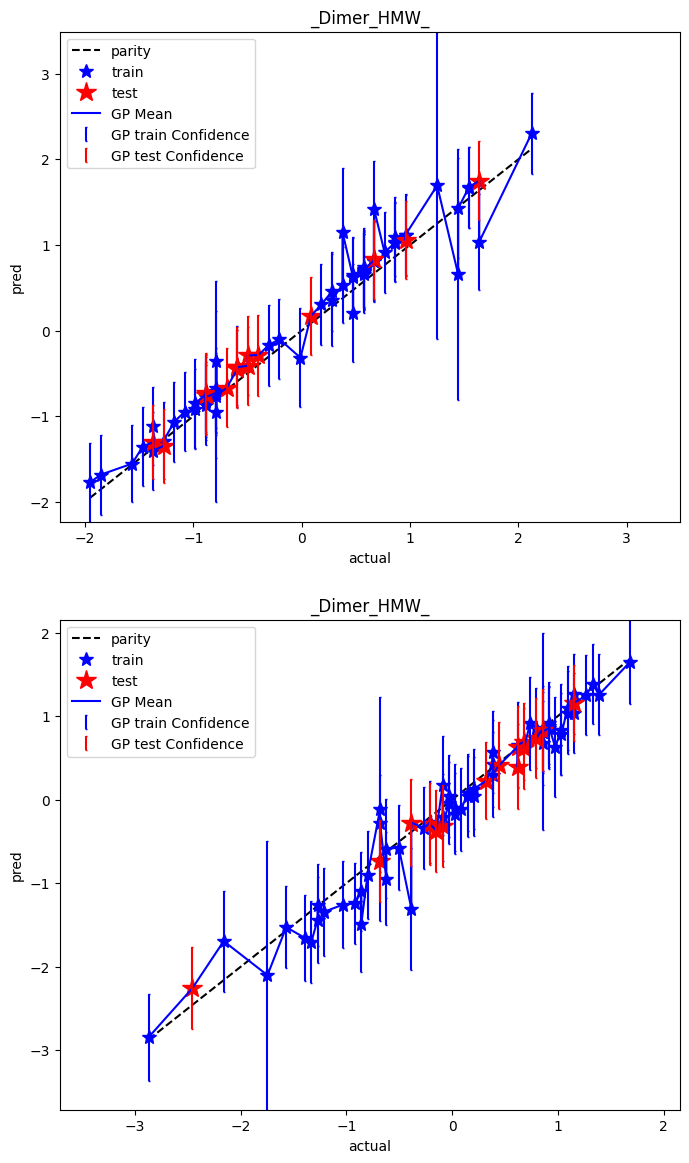

In [43]:
#from sklearn.metrics import mean_squared_error
figPath = setup_data.output_path
uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False


plot_axis_lb = df_y_long.min(axis = 0) - 0.4 * df_y_long.std(axis = 0)
plot_axis_ub = df_y_long.max(axis = 0) + 0.4 * df_y_long.std(axis = 0)

num_outputs = 1#len(cols_target)
num_tasks = len(cols_target)#len(df_X_train['task_ind'].unique())

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j in range(num_outputs):
    a = j + num_outputs*task_ind
    tmp_col_y = cols_target[j]

    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])


df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
f = "{:,.2f}"
for col in df_test_metrics:
  df_test_metrics[col] = df_test_metrics[col].map(lambda x: f.format(x))


for col in df_train_metrics:
  df_train_metrics[col] = df_train_metrics[col].map(lambda x: f.format(x))

print('Test Metrics:')
print(df_test_metrics)
print('Train Metrics:')
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')